# Compare Hierarchical Joint Inference Results - v6

**Key updates from v5:**
1. Supports hierarchical results with `theta_X`, `theta_D` and `X_fine`, `D_fine`
2. Added **2D scatter plots** of βR vs βI posteriors with coupling status in title
3. Use only **|E[β]|** (norm of posterior mean) - removed biased E[|β|] comparisons
4. Heatmaps: Only mark TRUE couplings with ★, no markers for uncoupled
5. Log-scale W statistic heatmap to handle extreme values

In [1]:
import sys, os, pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.colors import ListedColormap, LogNorm
import matplotlib.patheffects as patheffects
from scipy.signal import fftconvolve
from scipy import stats
from simulate_trial_data import TrialSimConfig
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

project_root = "/orcd/data/ekmiller/001/bowen/spike_field_joint_inference"
# add project root to sys.path
if project_root not in sys.path:
    sys.path.insert(0, project_root)


In [2]:
# Configuration
DATA_PATH = "./data/sim_with_trials.pkl"
RESULTS_PATH = "./results/joint_inference.pkl"  # Updated for hierarchical
OUTPUT_DIR = "./figures/"
os.makedirs(OUTPUT_DIR, exist_ok=True)
KEEP_FIRST = 0.3
SIGNIFICANCE_THRESHOLD = 0.05
CREDIBLE_INTERVAL = 0.95
BURNIN_FRAC = 0.5
THIN = 2

COLOR_PERCENTILE = 99
EFFECT_CMAP = 'Reds'

## 1. Load Data

In [3]:
from simulate_trial_data import TrialSimConfig
with open(DATA_PATH, "rb") as f:
    data = pickle.load(f)

LFP = data["LFP"]
spikes = data["spikes"]
freqs_true = np.asarray(data["freqs_hz"], float)
freqs_coupled = np.asarray(data.get("freqs_hz_coupled", freqs_true), float)
freqs_extra = np.asarray(data.get("freqs_hz_extra", []), float)
freqs_true_int = freqs_true.astype(int)
freqs_coupled_int = freqs_coupled.astype(int)
freqs_extra_int = freqs_extra.astype(int)
freqs_extra_set = set(freqs_extra_int.tolist())
masks = np.asarray(data["masks"], bool)
delta_spk = float(data.get("delta_spk", 0.001))

if 'beta_mag' in data:
    beta_mag_true = np.asarray(data['beta_mag'])
    beta_phase_true = np.asarray(data['beta_phase'])
else:
    beta_true = np.asarray(data["beta_true"])
    J = len(freqs_true)
    betaR, betaI = beta_true[:, 1:1+J], beta_true[:, 1+J:1+2*J]
    beta_mag_true = np.sqrt(betaR**2 + betaI**2)
    beta_phase_true = np.arctan2(betaI, betaR)

# Compute true βR and βI from magnitude and phase
beta_R_true = beta_mag_true * np.cos(beta_phase_true)
beta_I_true = beta_mag_true * np.sin(beta_phase_true)

R, T = LFP.shape
_, n_units, T_fine = spikes.shape
J_true = len(freqs_true)
fs = 1000.0

print(f"LFP: {LFP.shape}, Spikes: {spikes.shape}")
print(f"True frequencies: {freqs_true}")
print(f"Coupling mask:\n{masks}")

print("\nGround Truth |β|:")
for s in range(n_units):
    coupled = [f"{freqs_true[j]:.0f}Hz={beta_mag_true[s,j]:.3f}" for j in range(J_true) if masks[s,j]]
    print(f"  Unit {s}: {', '.join(coupled)}")

LFP: (100, 10000), Spikes: (100, 5, 10000)
True frequencies: [11. 19. 27. 43.  7. 35.]
Coupling mask:
[[ True  True  True False False False]
 [ True  True False  True False False]
 [False  True  True  True False False]
 [ True  True  True False False False]
 [ True  True  True False False False]]

Ground Truth |β|:
  Unit 0: 11Hz=0.111, 19Hz=0.070, 27Hz=0.100
  Unit 1: 11Hz=0.145, 19Hz=0.078, 43Hz=0.059
  Unit 2: 19Hz=0.029, 27Hz=0.145, 43Hz=0.059
  Unit 3: 11Hz=0.039, 19Hz=0.039, 27Hz=0.047
  Unit 4: 11Hz=0.123, 19Hz=0.054, 27Hz=0.144


## 2. Load Hierarchical Joint Inference Results

In [4]:
with open(RESULTS_PATH, "rb") as f:
    results = pickle.load(f)

trace_beta = results['trace']['beta']
freqs_dense = results['freqs_dense']
B = len(freqs_dense)

print(f"Trace shape: {trace_beta.shape}")
print(f"Dense freqs: {B} from {freqs_dense[0]} to {freqs_dense[-1]} Hz")

# Check for hierarchical results
if 'theta_X' in results:
    print(f"\nHierarchical model detected:")
    print(f"  θ_X (shared): λ range [{results['theta_X']['lam'].min():.2f}, {results['theta_X']['lam'].max():.2f}]")
    print(f"  θ_D (per-trial): λ range [{results['theta_D']['lam'].min():.2f}, {results['theta_D']['lam'].max():.2f}]")
    
if 'X_fine' in results['trace']:
    print(f"  X_fine samples: {len(results['trace']['X_fine'])}")
if 'D_fine' in results['trace']:
    print(f"  D_fine samples: {len(results['trace']['D_fine'])}")

# Map true frequencies to dense grid indices
idx_map = np.array([np.argmin(np.abs(freqs_dense - f)) for f in freqs_true])
print(f"\nTrue freq -> Dense idx mapping:")
for j, f in enumerate(freqs_true):
    print(f"  {f:.0f} Hz -> idx {idx_map[j]} (dense={freqs_dense[idx_map[j]]:.0f} Hz)")

Trace shape: (800, 5, 61)
Dense freqs: 30 from 1.0 to 59.0 Hz

Hierarchical model detected:
  θ_X (shared): λ range [0.00, 23.03]
  θ_D (per-trial): λ range [0.00, 57.56]

True freq -> Dense idx mapping:
  11 Hz -> idx 5 (dense=11 Hz)
  19 Hz -> idx 9 (dense=19 Hz)
  27 Hz -> idx 13 (dense=27 Hz)
  43 Hz -> idx 21 (dense=43 Hz)
  7 Hz -> idx 3 (dense=7 Hz)
  35 Hz -> idx 17 (dense=35 Hz)


## 3. Compute Posterior Statistics

Using **|E[β]|** = √(E[βR]² + E[βI]²) — norm of the posterior mean (correct for significance testing)

In [5]:
# Apply burnin and thinning
n_samples_raw = trace_beta.shape[0]
burnin = int(BURNIN_FRAC * n_samples_raw)

postB = trace_beta[burnin::THIN]
Nsamp = postB.shape[0]

print(f"Raw samples: {n_samples_raw}, After burnin/thin: {Nsamp}")

# Extract real and imaginary parts
beta_R_post = postB[:, :, 1:1+B]       # (Nsamp, S, B)
beta_I_post = postB[:, :, 1+B:1+2*B]   # (Nsamp, S, B)

print(f"β_R range: [{beta_R_post.min():.4f}, {beta_R_post.max():.4f}]")
print(f"β_I range: [{beta_I_post.min():.4f}, {beta_I_post.max():.4f}]")

Raw samples: 800, After burnin/thin: 200
β_R range: [-0.2243, 0.3334]
β_I range: [-0.1968, 0.2869]


In [6]:
# ============================================================================
# Posterior mean and |E[β]| (norm of mean) - CORRECT for significance testing
# ============================================================================
mean_R = np.mean(beta_R_post, axis=0)  # (S, B)
mean_I = np.mean(beta_I_post, axis=0)  # (S, B)

# |E[β]| = norm of posterior mean
mag_norm_of_mean = np.sqrt(mean_R**2 + mean_I**2)  # (S, B)

# Phase from posterior mean
phase_mean = np.arctan2(mean_I, mean_R)  # (S, B)

print(f"|E[β]| range: [{mag_norm_of_mean.min():.4f}, {mag_norm_of_mean.max():.4f}]")

|E[β]| range: [0.0000, 0.0492]


In [7]:
# ============================================================================
# Wald test for H₀: β = 0
# W = μᵀΣ⁻¹μ ~ χ²(2) under H₀
# ============================================================================
W_all = np.zeros((n_units, B))
pvals_all = np.zeros((n_units, B))

for s in range(n_units):
    for j in range(B):
        br = beta_R_post[:, s, j]
        bi = beta_I_post[:, s, j]
        
        # Posterior mean
        mu = np.array([np.mean(br), np.mean(bi)])
        
        # Posterior covariance
        X = np.column_stack([br, bi])
        Sigma = np.cov(X, rowvar=False, ddof=1)
        
        # Add small ridge for stability
        Sigma = Sigma + 1e-10 * np.eye(2)
        
        # Wald statistic: W = μᵀΣ⁻¹μ
        try:
            W_all[s, j] = mu @ np.linalg.solve(Sigma, mu)
            pvals_all[s, j] = 1 - stats.chi2.cdf(W_all[s, j], df=2)
        except np.linalg.LinAlgError:
            W_all[s, j] = 0.0
            pvals_all[s, j] = 1.0

print(f"W range: [{W_all.min():.2f}, {W_all.max():.2f}]")
print(f"log₁₀(W+1) range: [{np.log10(W_all.min()+1):.2f}, {np.log10(W_all.max()+1):.2f}]")
print(f"p-value range: [{pvals_all.min():.2e}, {pvals_all.max():.4f}]")

W range: [0.00, 477.21]
log₁₀(W+1) range: [0.00, 2.68]
p-value range: [0.00e+00, 0.9998]


In [8]:
# ============================================================================
# FDR correction for significance (at true frequencies only for confusion matrix)
# ============================================================================
from scipy.stats import false_discovery_control

# Significance across ALL frequencies (for heatmap)
sig_joint = np.zeros_like(pvals_all, dtype=bool)
for s in range(n_units):
    pv = pvals_all[s]
    # BH-FDR correction
    adjusted_pv = false_discovery_control(pv, method='bh')
    reject = adjusted_pv <= SIGNIFICANCE_THRESHOLD
    sig_joint[s] = reject

# Extract significance at TRUE frequencies
sig_at_true = sig_joint[:, idx_map]  # (S, J_true)

print(f"Significant bands per unit: {sig_joint.sum(axis=1)}")
print(f"Significant at true frequencies: {sig_at_true.sum()} / {n_units * J_true}")

Significant bands per unit: [3 3 3 3 3]
Significant at true frequencies: 15 / 30


## 4. Detection Metrics at True Frequencies

In [9]:
# ============================================================================
# Compute TP/FP/TN/FN at TRUE frequencies
# ============================================================================
TP = np.sum(sig_at_true & masks)
FN = np.sum(~sig_at_true & masks)
FP = np.sum(sig_at_true & ~masks)
TN = np.sum(~sig_at_true & ~masks)

n_coupled = masks.sum()
n_uncoupled = (~masks).sum()

sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

print("Confusion Matrix at TRUE frequencies:")
print(f"              Detected   Not Detected")
print(f"  Coupled        {TP:3d}         {FN:3d}      (total: {n_coupled})")
print(f"  Not Coupled    {FP:3d}         {TN:3d}      (total: {n_uncoupled})")
print(f"\n  Sensitivity (TP rate): {sensitivity:.1%} ({TP}/{TP+FN})")
print(f"  Specificity (TN rate): {specificity:.1%} ({TN}/{TN+FP})")

Confusion Matrix at TRUE frequencies:
              Detected   Not Detected
  Coupled         15           0      (total: 15)
  Not Coupled      0          15      (total: 15)

  Sensitivity (TP rate): 100.0% (15/15)
  Specificity (TN rate): 100.0% (15/15)


In [10]:
# Detailed breakdown
print("\nDetailed breakdown at TRUE frequencies:")
print("="*80)

# Extract at true frequencies
mag_at_true = mag_norm_of_mean[:, idx_map]  # |E[β]|
W_at_true = W_all[:, idx_map]
pvals_at_true = pvals_all[:, idx_map]
phase_at_true = phase_mean[:, idx_map]

for s in range(n_units):
    print(f"\nUnit {s}:")
    for j, f in enumerate(freqs_true):
        coupled = masks[s, j]
        sig = sig_at_true[s, j]
        W_val = W_at_true[s, j]
        mag_val = mag_at_true[s, j]
        p_val = pvals_at_true[s, j]
        
        if coupled and sig:
            status = "TP ✓"
        elif coupled and not sig:
            status = "FN ✗"
        elif not coupled and sig:
            status = "FP ✗"
        else:
            status = "TN ✓"
        
        coupled_str = "COUPLED" if coupled else "------"
        sig_str = "SIG" if sig else "---"
        
        print(f"  {f:5.0f}Hz: {coupled_str} {sig_str} | W={W_val:8.1f} | p={p_val:.2e} | |E[β]|={mag_val:.4f} | {status}")


Detailed breakdown at TRUE frequencies:

Unit 0:
     11Hz: COUPLED SIG | W=   122.0 | p=0.00e+00 | |E[β]|=0.0307 | TP ✓
     19Hz: COUPLED SIG | W=   323.8 | p=0.00e+00 | |E[β]|=0.0225 | TP ✓
     27Hz: COUPLED SIG | W=   407.2 | p=0.00e+00 | |E[β]|=0.0345 | TP ✓
     43Hz: ------ --- | W=     0.4 | p=8.25e-01 | |E[β]|=0.0003 | TN ✓
      7Hz: ------ --- | W=     0.3 | p=8.50e-01 | |E[β]|=0.0001 | TN ✓
     35Hz: ------ --- | W=     0.2 | p=9.23e-01 | |E[β]|=0.0001 | TN ✓

Unit 1:
     11Hz: COUPLED SIG | W=   114.4 | p=0.00e+00 | |E[β]|=0.0399 | TP ✓
     19Hz: COUPLED SIG | W=   324.0 | p=0.00e+00 | |E[β]|=0.0260 | TP ✓
     27Hz: ------ --- | W=     0.1 | p=9.75e-01 | |E[β]|=0.0001 | TN ✓
     43Hz: COUPLED SIG | W=    90.2 | p=0.00e+00 | |E[β]|=0.0162 | TP ✓
      7Hz: ------ --- | W=     0.3 | p=8.57e-01 | |E[β]|=0.0001 | TN ✓
     35Hz: ------ --- | W=     0.0 | p=1.00e+00 | |E[β]|=0.0000 | TN ✓

Unit 2:
     11Hz: ------ --- | W=     0.7 | p=6.93e-01 | |E[β]|=0.0003 | TN ✓
   

## 5. 2D Scatter Plots: βR vs βI Posterior Samples

For each unit and TRUE frequency, plot the posterior samples of (βR, βI).
Title indicates whether this is a **Coupled** or **Uncoupled** pair.

In [11]:
def plot_beta_posterior_scatter(beta_R_samples, beta_I_samples, coupled, freq_hz, unit_idx, ax, signal_only=False):
    """
    Plot 2D scatter of βR vs βI posterior samples.
    
    Parameters
    ----------
    beta_R_samples : (N,) array of βR samples
    beta_I_samples : (N,) array of βI samples  
    coupled : bool - whether this is a coupled pair
    freq_hz : frequency in Hz
    unit_idx : unit index
    ax : matplotlib axes
    """
    # Posterior mean
    mean_R = np.mean(beta_R_samples)
    mean_I = np.mean(beta_I_samples)
    
    # Plot samples
    ax.scatter(beta_R_samples, beta_I_samples, alpha=0.3, s=10, c='tab:blue')
    
    # Plot posterior mean
    ax.scatter([mean_R], [mean_I], c='red', s=100, marker='x', linewidths=2, 
               label=f'E[β]', zorder=10)
    
    # Add origin
    ax.axhline(0, color='gray', linestyle='--', alpha=0.5, linewidth=0.5)
    ax.axvline(0, color='gray', linestyle='--', alpha=0.5, linewidth=0.5)
    
    # Compute 95% confidence ellipse
    cov = np.cov(beta_R_samples, beta_I_samples)
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    order = eigenvalues.argsort()[::-1]
    eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
    
    # Chi-squared value for 95% confidence with 2 DOF
    chi2_val = stats.chi2.ppf(0.95, 2)
    width, height = 2 * np.sqrt(eigenvalues * chi2_val)
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    
    ellipse = Ellipse((mean_R, mean_I), width, height, angle=angle,
                      fill=False, color='red', linestyle='-', linewidth=1.5,
                      label='95% CI')
    ax.add_patch(ellipse)
    
    # Title with coupling status
    if coupled:
        status = 'Coupled'
    else:
        status = 'Signal-only' if signal_only else 'Uncoupled'
    ax.set_title(f'Unit {unit_idx}, {freq_hz:.0f} Hz\n({status})', fontsize=10)
    
    ax.set_xlabel('βR')
    ax.set_ylabel('βI')
    ax.set_aspect('equal', adjustable='datalim')
    ax.legend(fontsize=8, loc='upper right')

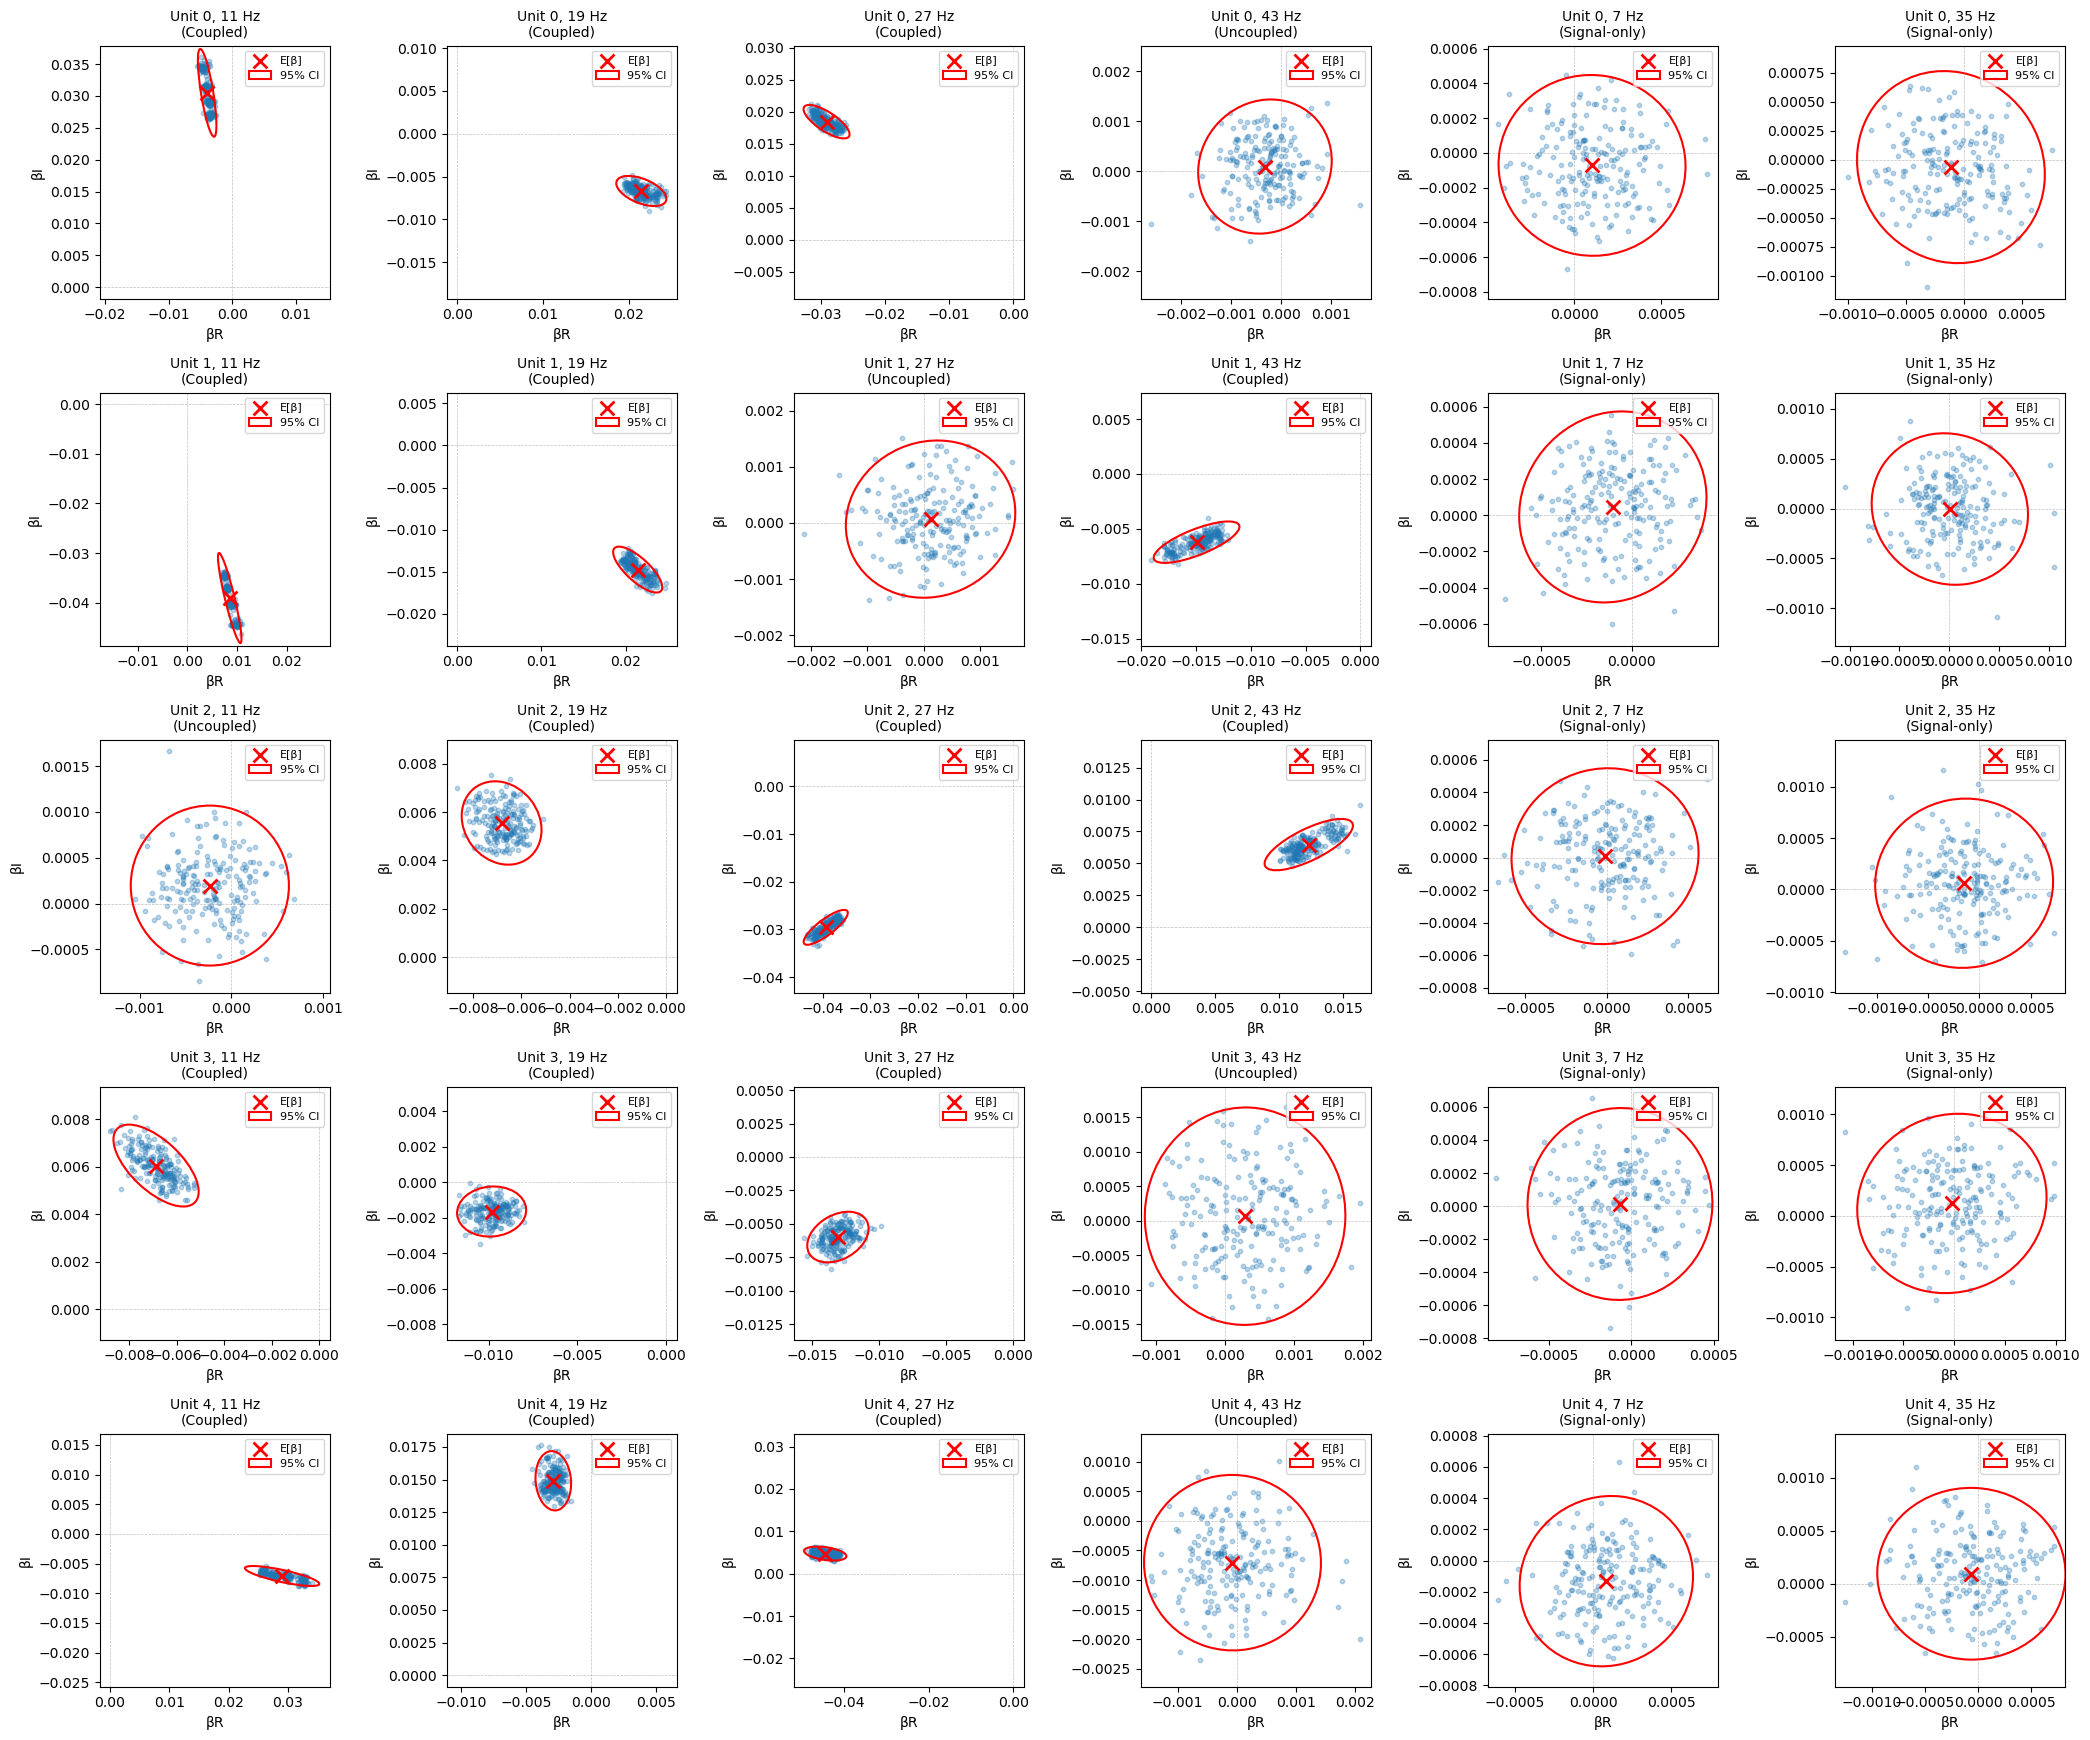


Saved to ./figures//beta_posterior_scatter_grid.png


In [12]:
# Create grid of scatter plots for all unit-frequency pairs at TRUE frequencies
fig, axes = plt.subplots(n_units, J_true, figsize=(3.5*J_true, 3.5*n_units))

for s in range(n_units):
    for j, f in enumerate(freqs_true):
        ax = axes[s, j] if n_units > 1 else axes[j]
        
        # Get dense grid index
        j_dense = idx_map[j]
        
        # Get posterior samples
        br = beta_R_post[:, s, j_dense]
        bi = beta_I_post[:, s, j_dense]
        
        # Is this coupled?
        coupled = masks[s, j]
        
        signal_only = (int(f) in freqs_extra_set)
        plot_beta_posterior_scatter(br, bi, coupled, f, s, ax, signal_only=signal_only)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/beta_posterior_scatter_grid.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSaved to {OUTPUT_DIR}/beta_posterior_scatter_grid.png")

Coupled pairs: 15
Uncoupled pairs: 15


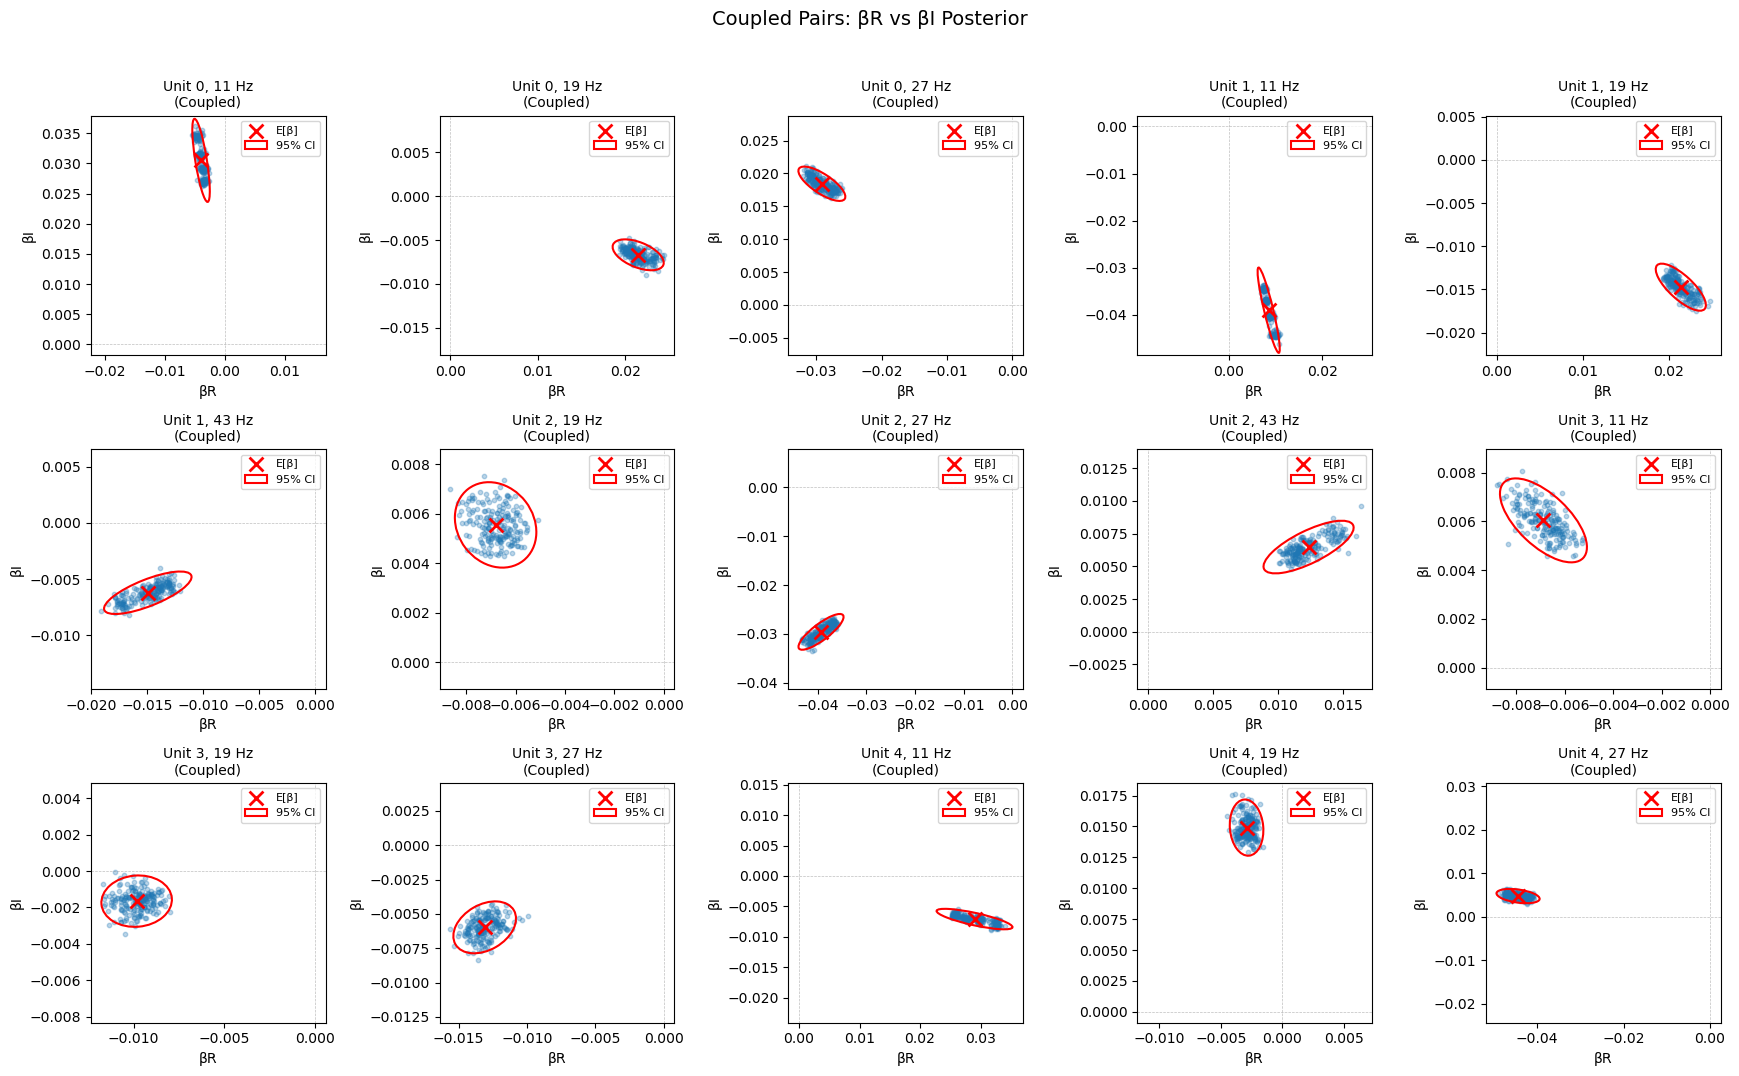

In [13]:
# Separate plots: Coupled vs Uncoupled
coupled_pairs = [(s, j, freqs_true[j]) for s in range(n_units) for j in range(J_true) if masks[s, j]]
uncoupled_pairs = [(s, j, freqs_true[j]) for s in range(n_units) for j in range(J_true) if not masks[s, j]]

print(f"Coupled pairs: {len(coupled_pairs)}")
print(f"Uncoupled pairs: {len(uncoupled_pairs)}")

# Plot coupled pairs
n_coupled = len(coupled_pairs)
n_cols = min(5, n_coupled)
n_rows = int(np.ceil(n_coupled / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.5*n_cols, 3.5*n_rows))
axes = np.atleast_2d(axes)

for idx, (s, j, f) in enumerate(coupled_pairs):
    row, col = idx // n_cols, idx % n_cols
    ax = axes[row, col]
    
    j_dense = idx_map[j]
    br = beta_R_post[:, s, j_dense]
    bi = beta_I_post[:, s, j_dense]
    
    plot_beta_posterior_scatter(br, bi, True, f, s, ax)

# Hide unused axes
for idx in range(n_coupled, n_rows * n_cols):
    row, col = idx // n_cols, idx % n_cols
    axes[row, col].set_visible(False)

plt.suptitle('Coupled Pairs: βR vs βI Posterior', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/beta_posterior_scatter_coupled.png', dpi=150, bbox_inches='tight')
plt.show()

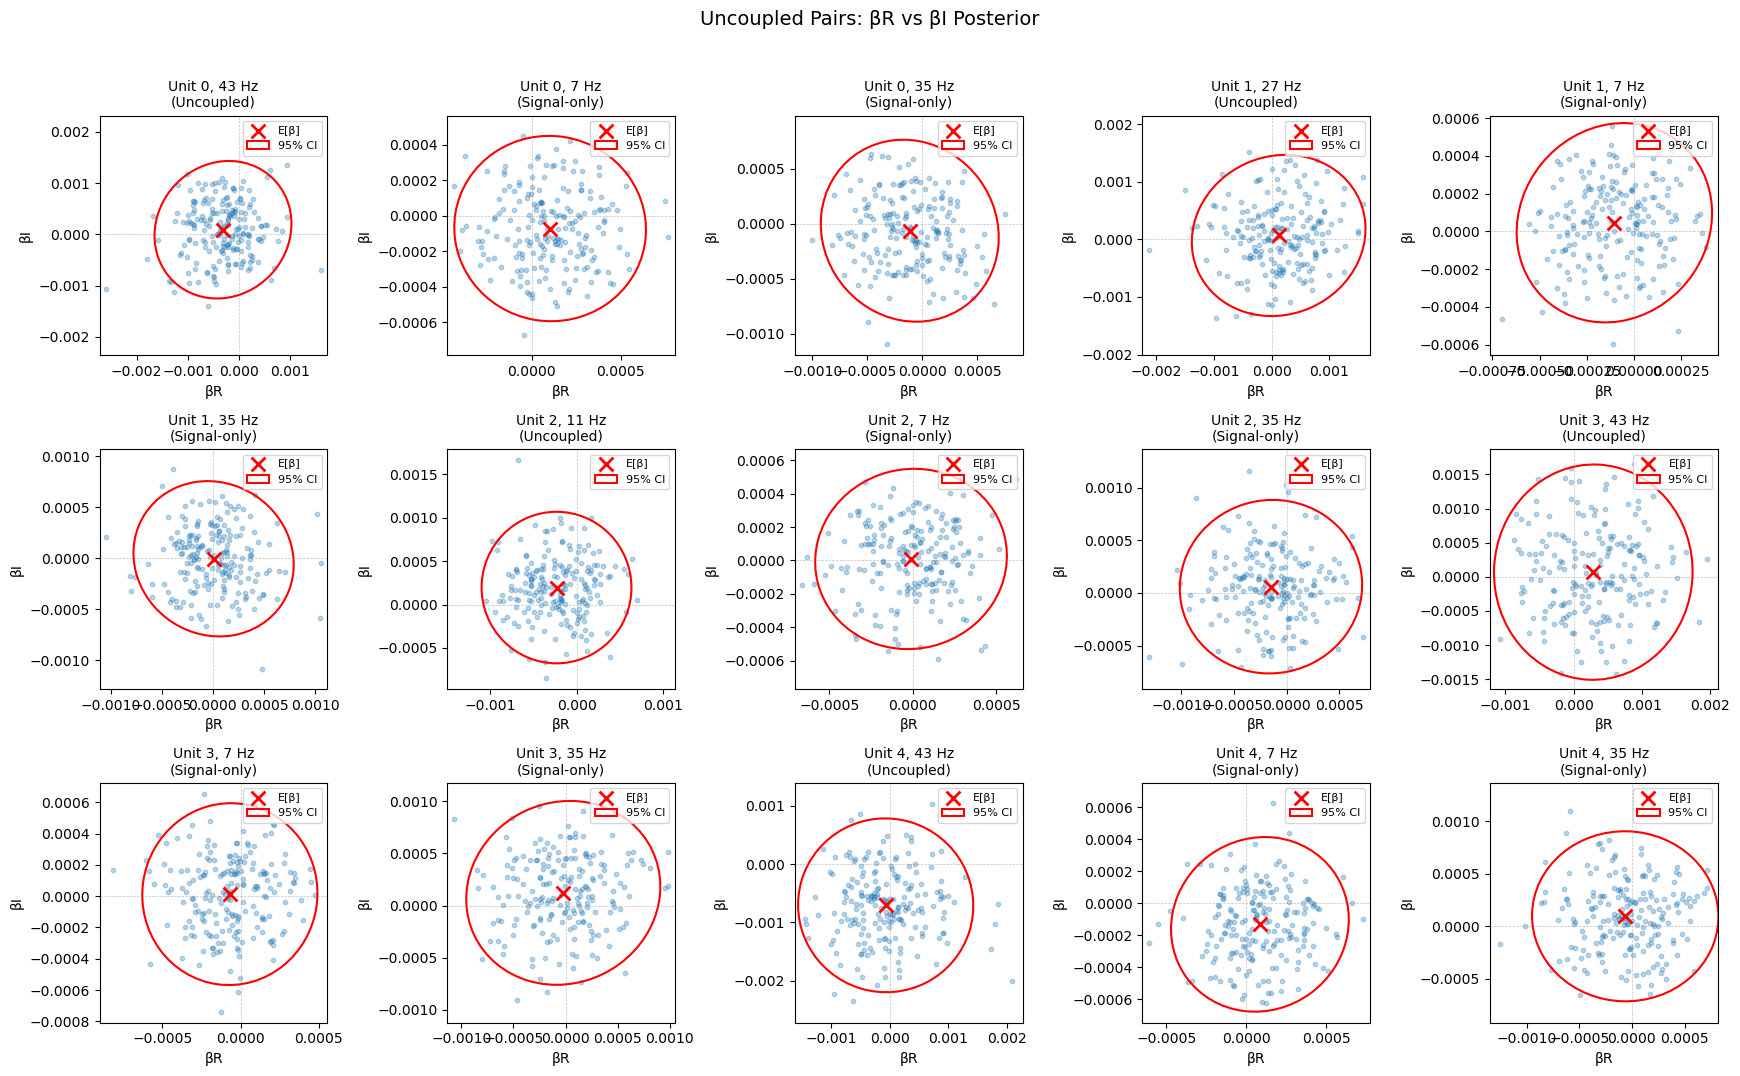

In [14]:
# Plot uncoupled pairs
n_uncoupled = len(uncoupled_pairs)
if n_uncoupled > 0:
    n_cols = min(5, n_uncoupled)
    n_rows = int(np.ceil(n_uncoupled / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.5*n_cols, 3.5*n_rows))
    if n_uncoupled == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes[np.newaxis, :]
    
    for idx, (s, j, f) in enumerate(uncoupled_pairs):
        row, col = idx // n_cols, idx % n_cols
        ax = axes[row, col]
        
        j_dense = idx_map[j]
        br = beta_R_post[:, s, j_dense]
        bi = beta_I_post[:, s, j_dense]
        
        signal_only = (int(f) in freqs_extra_set)
        plot_beta_posterior_scatter(br, bi, False, f, s, ax, signal_only=signal_only)
    
    # Hide unused axes
    for idx in range(n_uncoupled, n_rows * n_cols):
        row, col = idx // n_cols, idx % n_cols
        axes[row, col].set_visible(False)
    
    plt.suptitle('Uncoupled Pairs: βR vs βI Posterior', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/beta_posterior_scatter_uncoupled.png', dpi=150, bbox_inches='tight')
    plt.show()

## 6. Heatmaps

In [15]:
def plot_effect_heatmap(values, freqs, title, true_freqs=None, masks=None, coupled_freqs=freqs_coupled, extra_freqs=freqs_extra, 
                        log_scale=False, cmap='Reds'):
    """Plot heatmap with ★ markers ONLY at true coupled frequencies."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 3), 
                              gridspec_kw={'width_ratios': [20, 1]})
    
    if log_scale:
        plot_values = np.log10(values + 1)
        vmax = np.percentile(plot_values[np.isfinite(plot_values)], COLOR_PERCENTILE)
        cbar_label = 'log₁₀(W + 1)'
    else:
        plot_values = values
        vmax = np.percentile(plot_values[np.isfinite(plot_values)], COLOR_PERCENTILE)
        cbar_label = title
    
    im = axes[0].imshow(plot_values, aspect='auto', cmap=cmap, 
                        vmin=0, vmax=vmax,
                        extent=[freqs[0], freqs[-1], values.shape[0]-0.5, -0.5])

    # Mark signal-only bands (no spike coupling) as dotted vertical lines
    if extra_freqs is not None and len(extra_freqs) > 0:
        for f in extra_freqs:
            axes[0].axvline(float(f), color='black', linestyle=':', linewidth=1.0, alpha=0.6)
        axes[0].text(0.99, 1.02, 'dotted: signal-only', transform=axes[0].transAxes,
                     ha='right', va='bottom', fontsize=8)
    
    # Add ★ only at TRUE coupled frequencies
    if true_freqs is not None and masks is not None:
        idx_map_local = [np.argmin(np.abs(freqs - f)) for f in true_freqs]
        for s in range(masks.shape[0]):
            for j_true, j_dense in enumerate(idx_map_local):
                if masks[s, j_true]:  # Only mark coupled
                    freq_x = freqs[j_dense]
                    axes[0].text(freq_x, s, '★', fontsize=12, 
                                 ha='center', va='center', color='white',
                                 path_effects=[patheffects.withStroke(linewidth=2, foreground='black')])
    
    axes[0].set_xlabel('Frequency (Hz)')
    axes[0].set_ylabel('Unit')
    axes[0].set_title(title)
    axes[0].set_yticks(range(values.shape[0]))
    
    plt.colorbar(im, cax=axes[1], label=cbar_label)
    plt.tight_layout()
    return fig

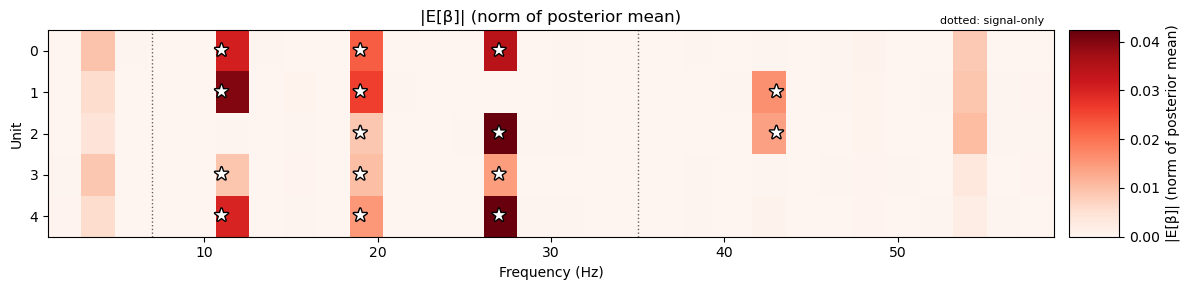

In [16]:
# |E[β]| heatmap
fig = plot_effect_heatmap(mag_norm_of_mean, freqs_dense, '|E[β]| (norm of posterior mean)',
                          true_freqs=freqs_true, masks=masks)
plt.savefig(f'{OUTPUT_DIR}/heatmap_mag_norm_mean.png', dpi=150, bbox_inches='tight')
plt.show()

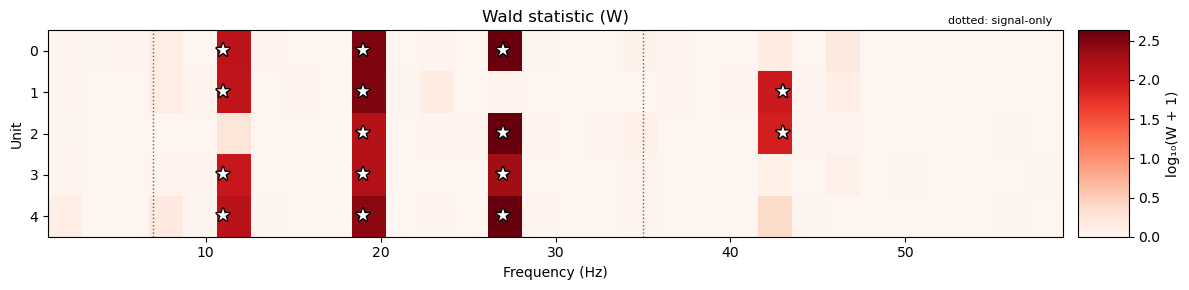

In [17]:
# W statistic heatmap (log scale)
fig = plot_effect_heatmap(W_all, freqs_dense, 'Wald statistic (W)',
                          true_freqs=freqs_true, masks=masks, log_scale=True)
plt.savefig(f'{OUTPUT_DIR}/heatmap_W_statistic.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. ROC Analysis

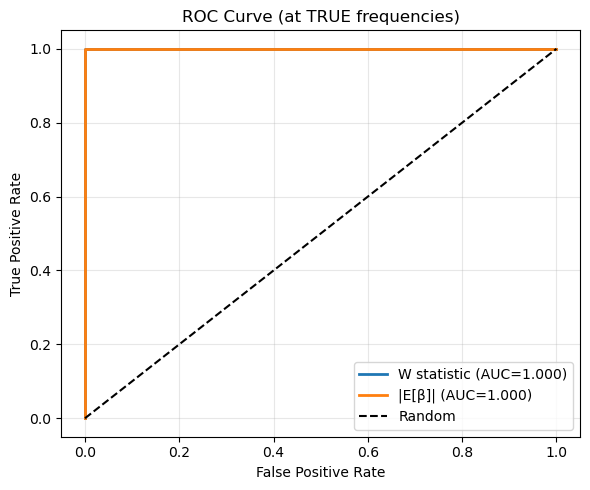

AUC (W statistic): 1.000
AUC (|E[β]|): 1.000


In [18]:
from sklearn.metrics import roc_curve, auc

# At TRUE frequencies only
W_true = W_all[:, idx_map].flatten()
mag_true = mag_norm_of_mean[:, idx_map].flatten()
labels_true = masks.flatten().astype(int)

# ROC for W statistic
fpr_W, tpr_W, _ = roc_curve(labels_true, W_true)
auc_W = auc(fpr_W, tpr_W)

# ROC for |E[β]|
fpr_mag, tpr_mag, _ = roc_curve(labels_true, mag_true)
auc_mag = auc(fpr_mag, tpr_mag)

# Plot
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(fpr_W, tpr_W, label=f'W statistic (AUC={auc_W:.3f})', lw=2)
ax.plot(fpr_mag, tpr_mag, label=f'|E[β]| (AUC={auc_mag:.3f})', lw=2)
ax.plot([0, 1], [0, 1], 'k--', label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve (at TRUE frequencies)')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/roc_curve.png', dpi=150)
plt.show()

print(f"AUC (W statistic): {auc_W:.3f}")
print(f"AUC (|E[β]|): {auc_mag:.3f}")

## 8. Magnitude Correlation

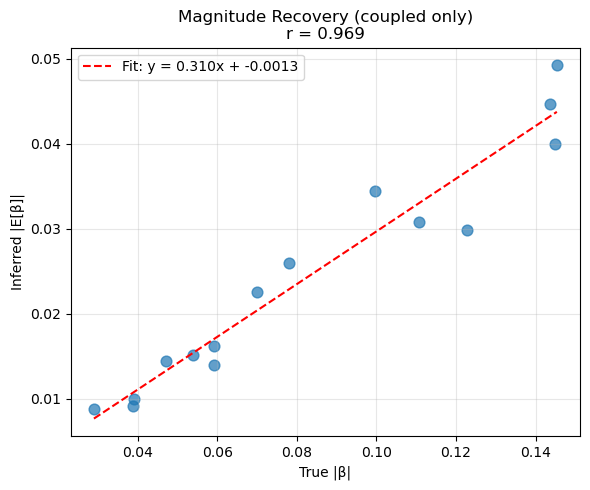

In [19]:
# At coupled frequencies only
true_mags = beta_mag_true[masks]
inferred_mags = mag_at_true[masks]

# Correlation
r = np.corrcoef(true_mags, inferred_mags)[0, 1]

fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(true_mags, inferred_mags, s=60, alpha=0.7)

# Fit line
if len(true_mags) > 1:
    z = np.polyfit(true_mags, inferred_mags, 1)
    p = np.poly1d(z)
    x_line = np.linspace(true_mags.min(), true_mags.max(), 100)
    ax.plot(x_line, p(x_line), 'r--', label=f'Fit: y = {z[0]:.3f}x + {z[1]:.4f}')

ax.set_xlabel('True |β|')
ax.set_ylabel('Inferred |E[β]|')
ax.set_title(f'Magnitude Recovery (coupled only)\nr = {r:.3f}')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/magnitude_correlation.png', dpi=150)
plt.show()

## 9. Phase Comparison

In [20]:
# Collect phase data for coupled pairs
phase_data = []
for s in range(n_units):
    for j in range(J_true):
        if masks[s, j]:
            phase_data.append({
                'unit': s,
                'freq': freqs_true[j],
                'true': beta_phase_true[s, j],
                'inferred': phase_at_true[s, j],
            })

true_phases = np.array([d['true'] for d in phase_data])
inferred_phases = np.array([d['inferred'] for d in phase_data])

# Circular error
phase_errors = np.angle(np.exp(1j * (inferred_phases - true_phases)))
mean_error = np.angle(np.mean(np.exp(1j * phase_errors)))
std_error = np.sqrt(-2 * np.log(np.abs(np.mean(np.exp(1j * phase_errors)))))
mae = np.mean(np.abs(phase_errors))

print(f"Phase error statistics (coupled only):")
print(f"  Mean circular error: {np.degrees(mean_error):.1f}°")
print(f"  Circular std: {np.degrees(std_error):.1f}°")
print(f"  Mean absolute error: {np.degrees(mae):.1f}°")

Phase error statistics (coupled only):
  Mean circular error: -11.9°
  Circular std: 5.1°
  Mean absolute error: 11.9°


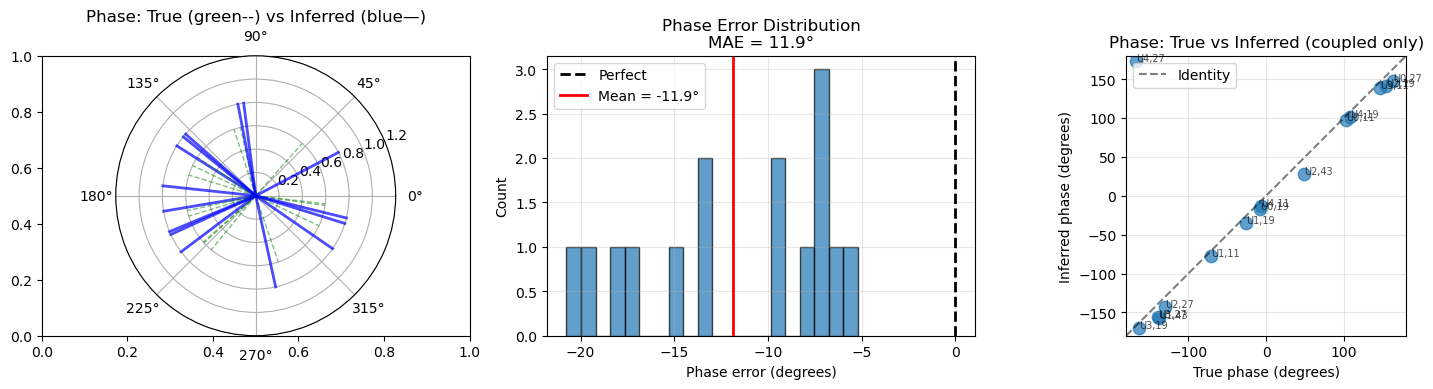

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Panel 1: Polar plot
ax = plt.subplot(131, projection='polar')
for d in phase_data:
    ax.plot([0, d['true']], [0, 0.6], 'g--', alpha=0.5, lw=1)
    ax.plot([0, d['inferred']], [0, 0.8], 'b-', alpha=0.7, lw=2)

ax.set_ylim([0, 1.2])
ax.set_title('Phase: True (green--) vs Inferred (blue—)')

# Panel 2: Phase error histogram
ax = axes[1]
ax.hist(np.degrees(phase_errors), bins=20, edgecolor='black', alpha=0.7, color='tab:blue')
ax.axvline(0, color='black', linestyle='--', lw=2, label='Perfect')
ax.axvline(np.degrees(mean_error), color='red', linestyle='-', lw=2, 
           label=f'Mean = {np.degrees(mean_error):.1f}°')
ax.set_xlabel('Phase error (degrees)')
ax.set_ylabel('Count')
ax.set_title(f'Phase Error Distribution\nMAE = {np.degrees(mae):.1f}°')
ax.legend()
ax.grid(alpha=0.3)

# Panel 3: True vs Inferred phase (scatter with identity line)
ax = axes[2]
ax.scatter(np.degrees(true_phases), np.degrees(inferred_phases), 
           c='tab:blue', s=80, alpha=0.7)
ax.plot([-180, 180], [-180, 180], 'k--', alpha=0.5, label='Identity')

for d in phase_data:
    ax.annotate(f'U{d["unit"]},{int(d["freq"])}', 
                (np.degrees(d['true']), np.degrees(d['inferred'])),
                fontsize=7, alpha=0.7)

ax.set_xlabel('True phase (degrees)')
ax.set_ylabel('Inferred phase (degrees)')
ax.set_title('Phase: True vs Inferred (coupled only)')
ax.set_xlim([-180, 180])
ax.set_ylim([-180, 180])
ax.set_aspect('equal')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/phase_comparison.png', dpi=150)
plt.show()

## 10. Summary

In [22]:
print("="*60)
print("SUMMARY")
print("="*60)

print(f"\nData: {n_units} units, {J_true} true frequencies")
print(f"  Coupled pairs: {masks.sum()}, Uncoupled pairs: {(~masks).sum()}")
print(f"  Posterior samples: {Nsamp} (after burnin/thinning)")

print(f"\n--- Detection (at TRUE frequencies) ---")
print(f"  Confusion matrix: TP={TP}, FN={FN}, FP={FP}, TN={TN}")
print(f"  Sensitivity: {sensitivity:.1%}")
print(f"  Specificity: {specificity:.1%}")

print(f"\n--- Ranking (ROC AUC) ---")
print(f"  W statistic: {auc_W:.3f}")
print(f"  |E[β]|:      {auc_mag:.3f}")

print(f"\n--- Magnitude Recovery (coupled only) ---")
print(f"  Correlation with true |β|: r = {r:.3f}")
print(f"  Mean |E[β]| coupled:   {mag_at_true[masks].mean():.4f} ± {mag_at_true[masks].std():.4f}")
print(f"  Mean |E[β]| uncoupled: {mag_at_true[~masks].mean():.4f} ± {mag_at_true[~masks].std():.4f}")

print(f"\n--- Phase Recovery (coupled only) ---")
print(f"  Mean circular error: {np.degrees(mean_error):.1f}°")
print(f"  Mean absolute error: {np.degrees(mae):.1f}°")

SUMMARY

Data: 5 units, 6 true frequencies
  Coupled pairs: 15, Uncoupled pairs: 15
  Posterior samples: 200 (after burnin/thinning)

--- Detection (at TRUE frequencies) ---
  Confusion matrix: TP=15, FN=0, FP=0, TN=15
  Sensitivity: 100.0%
  Specificity: 100.0%

--- Ranking (ROC AUC) ---
  W statistic: 1.000
  |E[β]|:      1.000

--- Magnitude Recovery (coupled only) ---
  Correlation with true |β|: r = 0.969
  Mean |E[β]| coupled:   0.0243 ± 0.0129
  Mean |E[β]| uncoupled: 0.0002 ± 0.0002

--- Phase Recovery (coupled only) ---
  Mean circular error: -11.9°
  Mean absolute error: 11.9°


In [23]:
# Save results
results_out = {
    'freqs_true': freqs_true,
    'freqs_dense': freqs_dense,
    'masks': masks,
    'beta_mag_true': beta_mag_true,
    'beta_phase_true': beta_phase_true,
    
    # Inferred values
    'mag_norm_of_mean': mag_norm_of_mean,
    'phase_mean': phase_mean,
    'mean_R': mean_R,
    'mean_I': mean_I,
    
    # Statistics
    'W_all': W_all,
    'pvals_all': pvals_all,
    'sig_joint': sig_joint,
    
    # Metrics
    'detection': {
        'TP': TP, 'FN': FN, 'FP': FP, 'TN': TN,
        'sensitivity': sensitivity,
        'specificity': specificity,
    },
    'auc': {
        'W': auc_W,
        'mag': auc_mag,
    },
    'magnitude_correlation': r,
    'phase_error': {
        'mean_circular': mean_error,
        'std_circular': std_error,
        'mae': mae,
    },
}

with open(f'{OUTPUT_DIR}/comparison_results_v6.pkl', 'wb') as f:
    pickle.dump(results_out, f)
print(f"Results saved to {OUTPUT_DIR}/comparison_results_v6.pkl")

Results saved to ./figures//comparison_results_v6.pkl
